In [12]:
import numpy as np 
import pandas as pd 
import datetime
from matplotlib import pyplot as plt
import os

%matplotlib inline

from data_provider import read_data_path, read_prices, read_data
from backtest import simulation
np.set_printoptions(edgeitems=30, linewidth=1000, formatter=dict(float=lambda x: "%.7g" % x))

In [73]:
pair = 'BTC'
data_path = read_data_path()
data_path = data_path + '/' + pair 
#files = glob(data_path + '/*')
#markets = [x.split('/')[-1] for x in files]
#markets = ['EOS-BTC','TRX-BTC', 'ONT-BTC', 'ZIL-BTC', 'VEN-BTC']
markets = ['BNB-BTC']

timeframes = ['3m', '5m', '15m', '24m', '30m', '1h']
timeframes = ['4h']#['15m' ,'30m ', '1h', '2h', '4h', '6h']


init_data = {'exchange_commission': 0.0005,
             'start_capital'     : 100,
             'buy_correction'    : 1.0001,
             'sell_correction'   : 0.9999,
             'robot_name'        : '',
             'market'            : '',
             'kline'             : ''  
            }

In [74]:
prediction_days = 30
price = read_prices(markets[0], timeframes[0])

df_train = price[:len(price)-prediction_days]
df_test  = price[len(price)-prediction_days:]

In [166]:
import tensorflow as tf
tf.__version__

'1.8.0'

In [75]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [158]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 32,  recurrent_dropout=0.25, dropout=0.25, input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))
regressor.add(Activation('linear'))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mse')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, validation_split= 0.3,
              batch_size = 32, epochs = 30)

Train on 1390 samples, validate on 596 samples
Epoch 1/30
1390/1390 [==============================] - 2s 1ms/step - loss: 0.0458 - val_loss: 0.2315
Epoch 2/30
1390/1390 [==============================] - 0s 98us/step - loss: 0.0231 - val_loss: 0.1371
Epoch 3/30
1390/1390 [==============================] - 0s 97us/step - loss: 0.0198 - val_loss: 0.1103
Epoch 4/30
1390/1390 [==============================] - 0s 97us/step - loss: 0.0170 - val_loss: 0.0811
Epoch 5/30
1390/1390 [==============================] - 0s 97us/step - loss: 0.0149 - val_loss: 0.0615
Epoch 6/30
1390/1390 [==============================] - 0s 97us/step - loss: 0.0147 - val_loss: 0.0489
Epoch 7/30
1390/1390 [==============================] - 0s 98us/step - loss: 0.0135 - val_loss: 0.0376
Epoch 8/30
1390/1390 [==============================] - 0s 97us/step - loss: 0.0133 - val_loss: 0.0367
Epoch 9/30
1390/1390 [==============================] - 0s 97us/step - loss: 0.0138 - val_loss: 0.0365
Epoch 10/30
1390/1390 [====

In [161]:
test_set = df_test
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)

In [162]:
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_price = regressor.predict(inputs)
predicted_price = sc.inverse_transform(predicted_price)

In [163]:
xt =  np.sign(np.diff(test_set[1:]))
x = np.reshape(predicted_price,-1)
xp = np.sign(np.diff(x[:-1]))
np.mean(xt == xp)


0.5

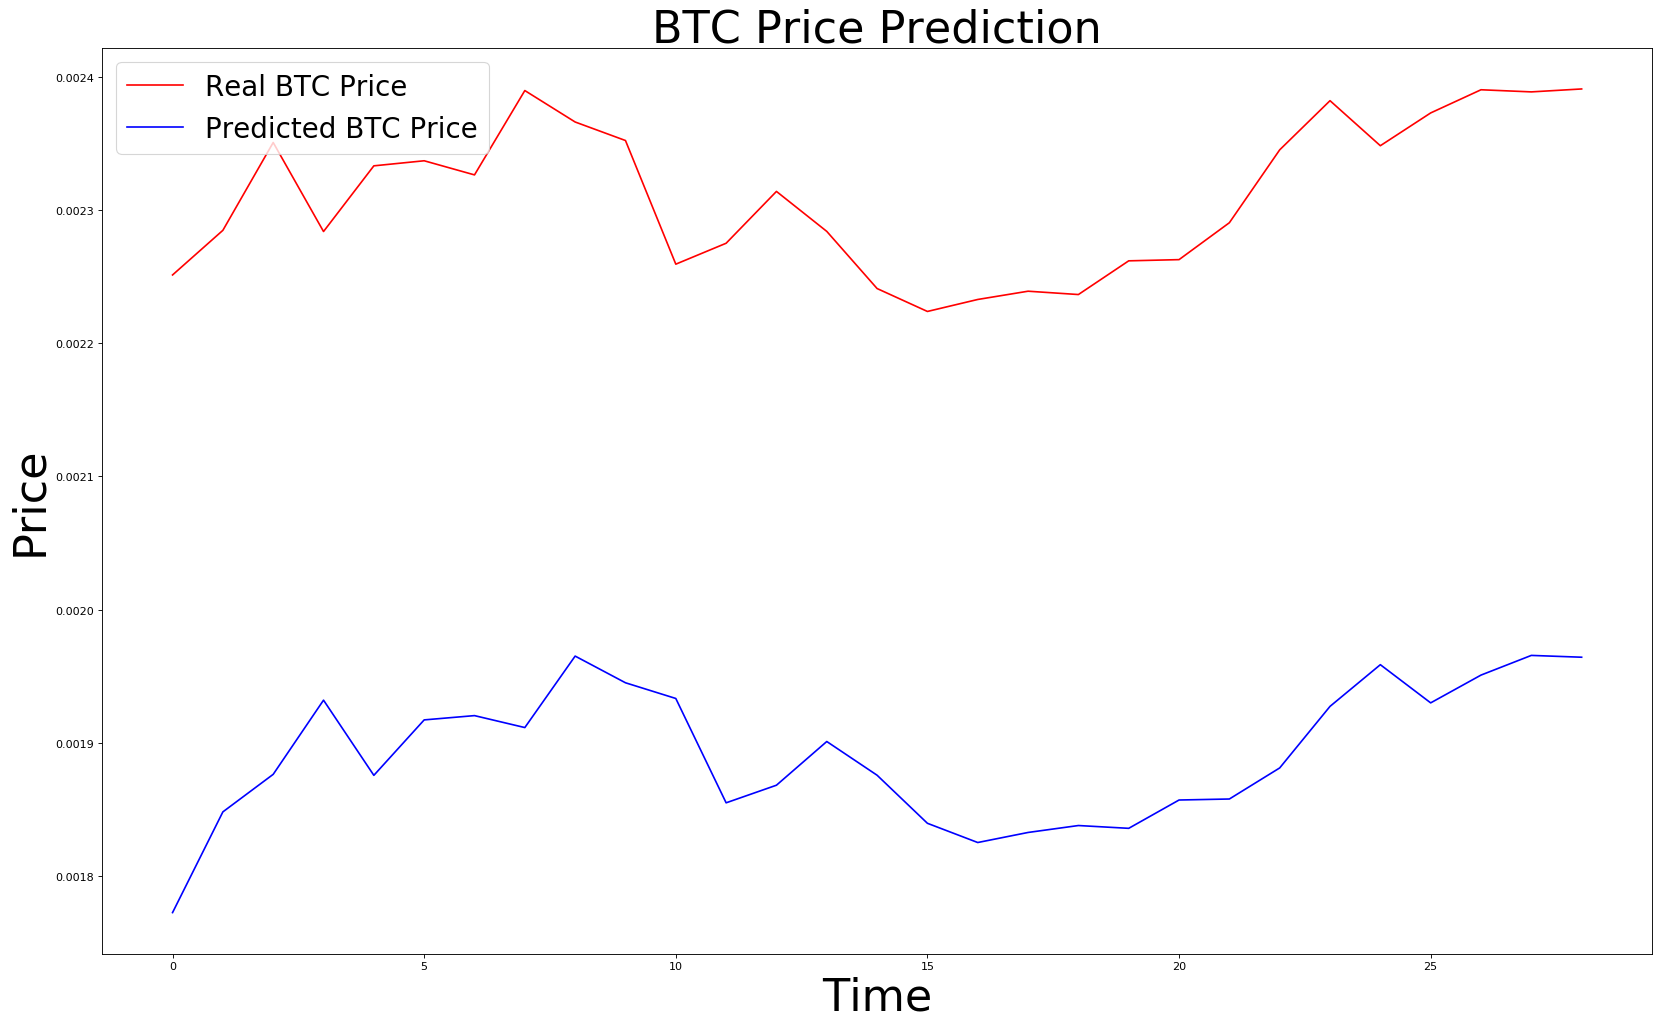

In [164]:
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set[1:], color = 'red', label = 'Real BTC Price')
plt.plot(predicted_price[:-1], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)

plt.xlabel('Time', fontsize=40)
plt.ylabel('Price', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()